In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Dropout
from keras.models import load_model
from keras.utils.vis_utils import plot_model

In [19]:
raw_data=pd.read_csv('APPLE.csv')
raw_data['Date']=pd.to_datetime(raw_data['Date'])
raw_data.drop("Adj Close",axis=1,inplace=True)
raw_data.head()


,Date,High,Low,Open,Close,Volume
0,2017-09-08,40.287498,39.632500,40.215000,39.657501,114446000.0
1,2017-09-11,40.512501,39.972500,40.125000,40.375000,126323200.0
2,2017-09-12,40.990002,39.692501,40.652500,40.215000,286856000.0
3,2017-09-13,39.990002,39.477501,39.967499,39.912498,179629600.0
4,2017-09-14,39.849998,39.522499,39.747501,39.570000,95042800.0


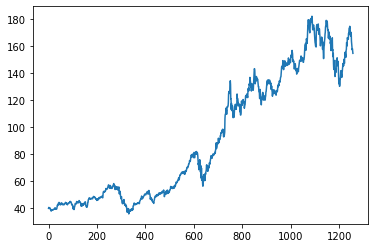

In [20]:
plt.plot(raw_data['Close'])

In [21]:
figure=go.Figure(go.Candlestick(close=raw_data['Close'],open=raw_data['Open'],high=raw_data['High'],low=raw_data['Low'],x=raw_data['Date']))
figure.show()

In [22]:
raw_data['Year']=pd.DatetimeIndex(data=raw_data['Date']).year
raw_data['Month']=pd.DatetimeIndex(data=raw_data['Date']).month
raw_data['Day']=pd.DatetimeIndex(data=raw_data['Date']).day
raw_data['Date']=(365*raw_data['Year'] +30*raw_data['Month'] +raw_data['Day'])/365
raw_data=raw_data.drop(['Year','Month','Day'],axis=1)



In [30]:
Moving_avg_7=raw_data['Close'].rolling(7).mean().shift()
Moving_avg_50=raw_data['Close'].rolling(50).mean().shift()
Moving_avg_100=raw_data['Close'].rolling(100).mean().shift()

Moving_avg_7_close=raw_data['Close'].rolling(7).mean().shift()[7:]
Moving_avg_7_open=raw_data['Open'].rolling(7).mean().shift()[7:]
Moving_avg_7_high=raw_data['High'].rolling(7).mean().shift()[7:]
Moving_avg_7_low=raw_data['Low'].rolling(7).mean().shift()[7:]


In [32]:
raw_data_linear=pd.DataFrame()
raw_data_lstm=pd.DataFrame()

raw_data_linear['close']=raw_data['Close'][7:]-Moving_avg_7_close
raw_data_linear['open']=raw_data['Open'][7:]-Moving_avg_7_open
raw_data_linear['high']=raw_data['High'][7:]-Moving_avg_7_high
raw_data_linear['low']=raw_data['Low'][7:]-Moving_avg_7_low
raw_data_linear['volume']=raw_data['Volume'].shift()[7:]

raw_data_lstm['close']=raw_data_linear['close']
raw_data_lstm['open']=raw_data_linear['open']
raw_data_lstm['high']=raw_data_linear['high']
raw_data_lstm['low']=raw_data_linear['low']
raw_data_lstm['volume']=raw_data_linear['volume']

In [33]:
raw_data_linear.describe()

,close,open,high,low,volume
count,1250.000000,1250.000000,1250.000000,1250.000000,1.250000e+03
mean,0.375122,0.381550,0.383419,0.372142,1.182873e+08
std,3.262792,3.303533,3.159121,3.262650,5.524833e+07
min,-13.791069,-16.214284,-13.618576,-14.762852,4.100000e+07
25%,-0.888926,-0.922321,-0.936428,-0.937501,8.138925e+07
50%,0.424642,0.407679,0.389106,0.461251,1.039130e+08
75%,1.827140,1.755089,1.711605,1.726518,1.384424e+08
max,13.078571,12.930711,14.859639,14.151430,4.265100e+08


In [8]:
training_size=int(0.65*len(raw_data_lstm))
new_data=raw_data_lstm['Close']


x_train=raw_data_lstm.iloc[0:training_size-1]
y_train=new_data[1:training_size]
x_test=raw_data_lstm.iloc[training_size:len(raw_data)-1]
y_test=new_data[training_size+1:len(raw_data)]


model_forests=RandomForestRegressor()
space_forests={'n_estimators':[25,50,75,100,200,250,500],'max_depth':[3,6,10,25,50,75,100],'max_features':[3,4],'min_samples_split':[3,5,8,10,12,15]}
search_forests=GridSearchCV(model_forests,space_forests,scoring='neg_mean_squared_error',cv=7)
result_forests=search_forests.fit(x_train,y_train)

model_forest=result_forests.best_estimator_
print("Score(RFR) on test set:",model_forest.score(x_test,y_test))

new_data_linear=raw_data_linear['Close']
x_train_linear=raw_data_linear.iloc[0:training_size-1]
y_train_linear=new_data_linear[1:training_size]
x_test_linear=raw_data_linear.iloc[training_size:len(raw_data)-1]
y_test_linear=new_data_linear[training_size+1:len(raw_data)]


model_linear=LinearRegression()
model_linear.fit(x_train_linear,y_train_linear)
print("Score(LR) on test set:",model_linear.score(x_test_linear,y_test_linear))



KeyboardInterrupt: 

In [45]:
def create_dataset(dataset,time_care=100):
    x_data,y_data=[],[]
    for i in range(len(dataset)-time_care-1):
        x=dataset.iloc[i:i+time_care]
        y=dataset.iloc[(i+time_care)]
        x_data.append(x)
        y_data.append(y)
        
    return np.array(x_data),np.array(y_data)


In [94]:
def Deep_Predictor(col,raw_data_lstm,time_care=100,epochs=50,redefine_model=0):
    name_of_predictor=col+"_Predictor.h5"
    feature_data=raw_data[col][:len(raw_data[col])]
    training_size=int(len(feature_data)*0.67)
    test_size=int(len(feature_data)-training_size)
    train_data,test_data=feature_data[0:training_size:1],feature_data[training_size:len(feature_data):1]
    x_train,y_train=create_dataset(train_data,time_care)
    x_test,y_test=create_dataset(test_data,time_care)
    x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_test.reshape(x_test.shape[0],x_test.shape[1],1)
    
    if (redefine_model==1):
        model=Sequential()
        model.add(LSTM(time_care,return_sequences=True,activation='relu',input_shape=(time_care,1)))
        model.add(LSTM(int(1.25*time_care),activation='relu',return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(int(1.5*time_care),return_sequences=True,activation='relu'))
        model.add(LSTM(int(1.75*time_care),activation='relu',return_sequences=True))
        model.add(Dropout(0.25))
        
        model.add(LSTM(int(2*time_care),activation='relu'))
        model.add(Dense(15))
        model.add(Dense(1))
        model.compile(loss='mse',optimizer='adam')    

        model.summary()
        model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=epochs,verbose=1)
        model.save(name_of_predictor)
        
        train_predict=model.predict(x_train)
        print("Training data yields:",mean_squared_error(train_predict,y_train))
        plot_model(model,show_shapes=True)
    
    else :
        model=load_model(name_of_predictor,compile=False) 
    return model

In [96]:
redefine_model=1
columns=['High','Low','Open','Close','Volume']

for col in columns:
    model=Deep_Predictor(col,raw_data_lstm,time_care=30,epochs=25,redefine_model=redefine_model)
    plot_model(model,show_shapes=True)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_141 (LSTM)             (None, 30, 30)            3840      
                                                                 
 lstm_142 (LSTM)             (None, 30, 37)            10064     
                                                                 
 dropout_56 (Dropout)        (None, 30, 37)            0         
                                                                 
 lstm_143 (LSTM)             (None, 30, 45)            14940     
                                                                 
 lstm_144 (LSTM)             (None, 30, 52)            20384     
                                                                 
 dropout_57 (Dropout)        (None, 30, 52)            0         
                                                                 
 lstm_145 (LSTM)             (None, 60)              

KeyboardInterrupt: 

In [ ]:
predictions_test=(model_forest.predict(x_test)).tolist()
predictions_train=(model_forest.predict(x_train)).tolist()
print(mean_squared_error(y_test,predictions_test))

In [ ]:
#plotting=predictions_train+predictions_test
plt.plot(raw_data['Close'])
plt.plot(Moving_avg_7)
plt.plot(Moving_avg_50)
plt.plot(Moving_avg_100)
plt.show()

# Backtesting Strategy

In [58]:
model_close=load_model("Close_Predictor.h5",compile=False)
model_open=load_model("Open_Predictor.h5",compile=False)
model_volume=load_model("Volume_Predictor.h5",compile=False)
model_high=load_model("High_Predictor.h5",compile=False)
model_low=load_model("Low_Predictor.h5",compile=False)

test=pd.DataFrame(columns=['date','Real_close','Predicted Close'])

for i in range(len(test_data)):
    data_considered=raw_data_lstm.iloc[len(train_data)-time_care+i:len(train_data)+i,:]
    close=model_close.predict(np.array(scale[3]*data_considered['close']).reshape(1,-1))
    openn=model_open.predict(np.array(scale[2]*data_considered['open']).reshape(1,-1))
    volume=model_volume.predict(np.array(scale[4]*data_considered['volume']).reshape(1,-1))
    high=model_high.predict(np.array(scale[0]*data_considered['high']).reshape(1,-1))
    low=model_low.predict(np.array(scale[1]*data_considered['low']).reshape(1,-1))
    
    #series_for_linear=[close,openn,high,low,volume]
    #predicted_dev=model_forest.predict(series_for_linear)
    Predicted_close=predicted_dev+Moving_avg_7_close[len(training_data+i)]
    
    
    series=pd.Series(x,index=['date','Real_close','Predicted Close'])
    x.append(raw_data['Date'][len(train_data)+i])
    x.append(raw_data['Close'][len(train_data)+i])
    x.append(float(Predicted_close))
    test.append(series)
    
    
for i in range(1,len(test)):
    if (test['Predicted Close'][i]>test['Predicted Close'][i-1]):
        test['signal'][i]=1
    elif(test['Predicted Close'][i]==test['Predicted Close'][i-1]):
        test['signal'][i]=test['signal'][i-1]
    else:
        test['signal'][i]=-1
        

for i in range(1,len(test)):
    test['buy'][i]=test['signal'][i-1]-test['signal'][i]

test['natural_return']=np.log(test['Real_close']).diff()
test['strategy_return']=test['natural_return']*test['signal']

std_deviation=np.std(test['strategy_return'])
final_return=np.exp(test['strategy_return']).cumprod()[-1]-1
natural_return=np.exp(test['natural_return']).cumprod()[-1]-1
max_drawdown_from_peak=max(np.exp(test['strategy_return']).cumprod())-min(np.exp(test['strategy_return']).cumprod())
max_drawdown_from_invested=min(np.exp(test['strategy_return']).cumprod())
sharpe_ratio=(final_return-natural_return)/std_deviation

print("sharpe ratio:",sharpe_ratio)
print("max drawdown from peak:",max_drawdown_from_peak)
print("max drawdown from invested:",max_drawdown_from_invested)

OSError: No file or directory found at Close_Predictor.h5

# Future Predictor

In [54]:
future_days=25
future_x=[]
future_y=[]
time_care=15

model_close=load_model("Close_Predictor.h5",compile=False)
model_open=load_model("Open_Predictor.h5",compile=False)
model_volume=load_model("Volume_Predictor.h5",compile=False)
model_high=load_model("High_Predictor.h5",compile=False)
model_low=load_model("Low_Predictor.h5",compile=False)

for i in range (future_days):
    x=[]
    data_considered=raw_data.iloc[len(raw_data)-time_care:len(raw_data),:]
    close=model_close.predict(np.array(scale[3]*data_considered['Close']).reshape(1,-1))
    openn=model_open.predict(np.array(scale[2]*data_considered['Open']).reshape(1,-1))
    volume=model_volume.predict(np.array(scale[4]*data_considered['Volume']).reshape(1,-1))
    high=model_high.predict(np.array(scale[0]*data_considered['High']).reshape(1,-1))
    low=model_low.predict(np.array(scale[1]*data_considered['Low']).reshape(1,-1))
        
    x.append(raw_data['Date'][len(raw_data)-1]+1/365)
    x.append(float(high+Moving_avg_7_high[-1]))
    x.append(float(low+Moving_avg_7_low[-1]))
    x.append(float(openn+Moving_avg_7_open[-1]))
    
    #series=pd.Series(x,index=raw_data_lstm.columns)
    
    close_forest=model_forest.predict(raw_data.iloc[len(raw_data)-1:len(raw_data),:])
    
    closing_price_final=(0.5*(float(close+Moving_avg_7_close[-1]))) +0.5*(float(close_forest+Moving_avg_7_close[-1]))
    
    
    future_y.append(closing_price_final)
    
    x.append(float(closing_price_final))
    x.append(float(volume))
    raw_data=raw_data.append(x,ignore_index=True)
    Moving_avg_7_high=raw_data['High'].rolling(7).mean().shift()
    Moving_avg_7_low=raw_data['Low'].rolling(7).mean().shift()
    Moving_avg_7_close=raw_data['Close'].rolling(7).mean().shift()
    Moving_avg_7_open=raw_data['Open'].rolling(7).mean().shift()
    


OSError: No file or directory found at Close_Predictor.h5

In [51]:
Moving_avg_7=raw_data['Close'].rolling(7).mean()
Moving_avg_50=raw_data['Close'].rolling(50).mean()
Moving_avg_100=raw_data['Close'].rolling(100).mean()


plotting=predictions_train+predictions_test+future_y
plt.plot(Moving_avg_7)
plt.plot(Moving_avg_50)
plt.plot(Moving_avg_100)
plt.plot(plotting)
plt.show()

NameError: name 'predictions_train' is not defined

In [52]:
raw_data.shape

(1257, 6)

In [53]:
raw_data.tail()

,Date,High,Low,Open,Close,Volume
1252,2022.739726,162.559998,157.720001,162.130005,158.910004,77906200.0
1253,2022.742466,160.580002,157.139999,160.309998,157.220001,87991100.0
1254,2022.742466,158.419998,154.669998,156.639999,157.960007,74229900.0
1255,2022.745205,160.360001,154.970001,159.750000,155.809998,76905200.0
1256,2022.756164,157.089996,153.690002,156.470001,154.529999,73604800.0
